In [1]:
import glob

import anndata
import dask
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from wmb import cemba
from scipy.stats import zscore

In [2]:
mcds_paths = "geneslop2k_frac.mcds"
var_dim = "geneslop2k"
cell_meta_path = "../221027_AMB_metadata.csv"
gene_meta_path = "/data/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz"

meta = pd.read_csv(cell_meta_path, index_col=0)
gene_meta = pd.read_csv(gene_meta_path, sep="\t")

gene_name_to_id = pd.Series(
    data=gene_meta["gene_id"].tolist(), index=gene_meta["gene_name"].tolist()
).to_dict()

gene_id_to_name = pd.Series(
    data=gene_meta["gene_name"].tolist(), index=gene_meta["gene_id"].tolist()
).to_dict()

In [3]:
celltype_dmg = pd.read_hdf('MajorType.OneVsRestDMG.hdf')
celltype_dmg.index = celltype_dmg.index.map(gene_id_to_name)

In [14]:
celltype_markers_dict = joblib.load('celltype_markers_dict')
celltype_order_list = joblib.load('celltype_order_list')

In [245]:
celltype_ro_marker_genes = {'DG Glut':['Dock10'],
 'SUB-ProS Glut':['Fbxl17'],
 'NP SUB Glut':['Ikzf2'],
 'CA1-ProS Glut':['Fibcd1'],
 'CA2 Glut':['Mctp1'],
 'CA3 Glut':['Rerg'],
 'L5 ET CTX Glut':['Tcerg1l'],
 'L2/3+L4/5 IT CTX Glut':['Prex1'],
 'L4/5 IT CTX Glut':['Ptgfrn'],
 'L6 IT CTX Glut':['Kcnip4'],
 'L5 NP CTX Glut':['Tshz2'],
 'L6 CT CTX Glut':['Tle4'],
 'LA-BLA-BMA-PA Glut':['Ank2'],
 'OLF-ENT Glut':['Lingo2'],
 'L2/3 IT ENT Glut':['Lingo2'],
 'L6b/CT ENT Glut':['Sept9'],
 'L2 IT PPP-APr Glut':['Ankrd44'],
 'L2/3 IT PPP Glut':['Map7'],
 'IT EP-CLA Glut':['March1'],
 'COA Glut':['Itpr2'],
 'Scdg Glut':['Zfhx3'],
 'MB-MY Glut-Sero':['Tns1'],
 'MSN D1 Gaba':['Drd1'],
 'MSN D2 Gaba':['Drd2'],
 'AMY Gaba':['Scn5a'],
 'STR-PAL Chst9 Gaba':['Adgrv1'],
 'STR Prox1 Lhx6 Gaba':['Ctif'],
 'Sst Chodl Gaba':['Adamts6'],
 'Sst Gaba':['Sst'],
 'Pvalb Gaba':['Pvalb'],
 'Vip Gaba':['Vip'],
 'Lamp5 Gaba':['Lamp5'],
 'Lamp5 Lhx6 Gaba':['Dlc1'],
 'PAG/PCG':['Camta1']}

In [246]:
marker_genes_order = []
celltype_order_list = []

for celltype, gene_markers in celltype_ro_marker_genes.items():
    celltype_order_list.append(celltype)
    marker_genes_order += gene_markers

marker_genes_ids = [gene_name_to_id[gene_name] for gene_name in marker_genes_order]

In [247]:
with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_paths, var_dim=var_dim, use_obs=meta.index).sel(
        geneslop2k=marker_genes_ids, mc_type="CHN"
    )

In [248]:
gene_frac_df = mcds["geneslop2k_da_frac"].to_pandas()
gene_frac_df["MajorType"] = meta["MajorType"]

In [249]:
to_plot = gene_frac_df.groupby("MajorType").mean().T
to_plot.index = to_plot.index.map(gene_id_to_name)
to_plot = to_plot.loc[marker_genes_order, celltype_order_list]

In [250]:
to_plot = to_plot.drop_duplicates(keep='first')

<AxesSubplot:ylabel='Density'>

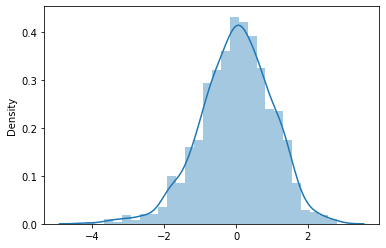

In [251]:
to_plot = to_plot.apply(zscore, axis = 1)
to_plot = to_plot.apply(zscore, axis = 0)
sns.distplot(to_plot)

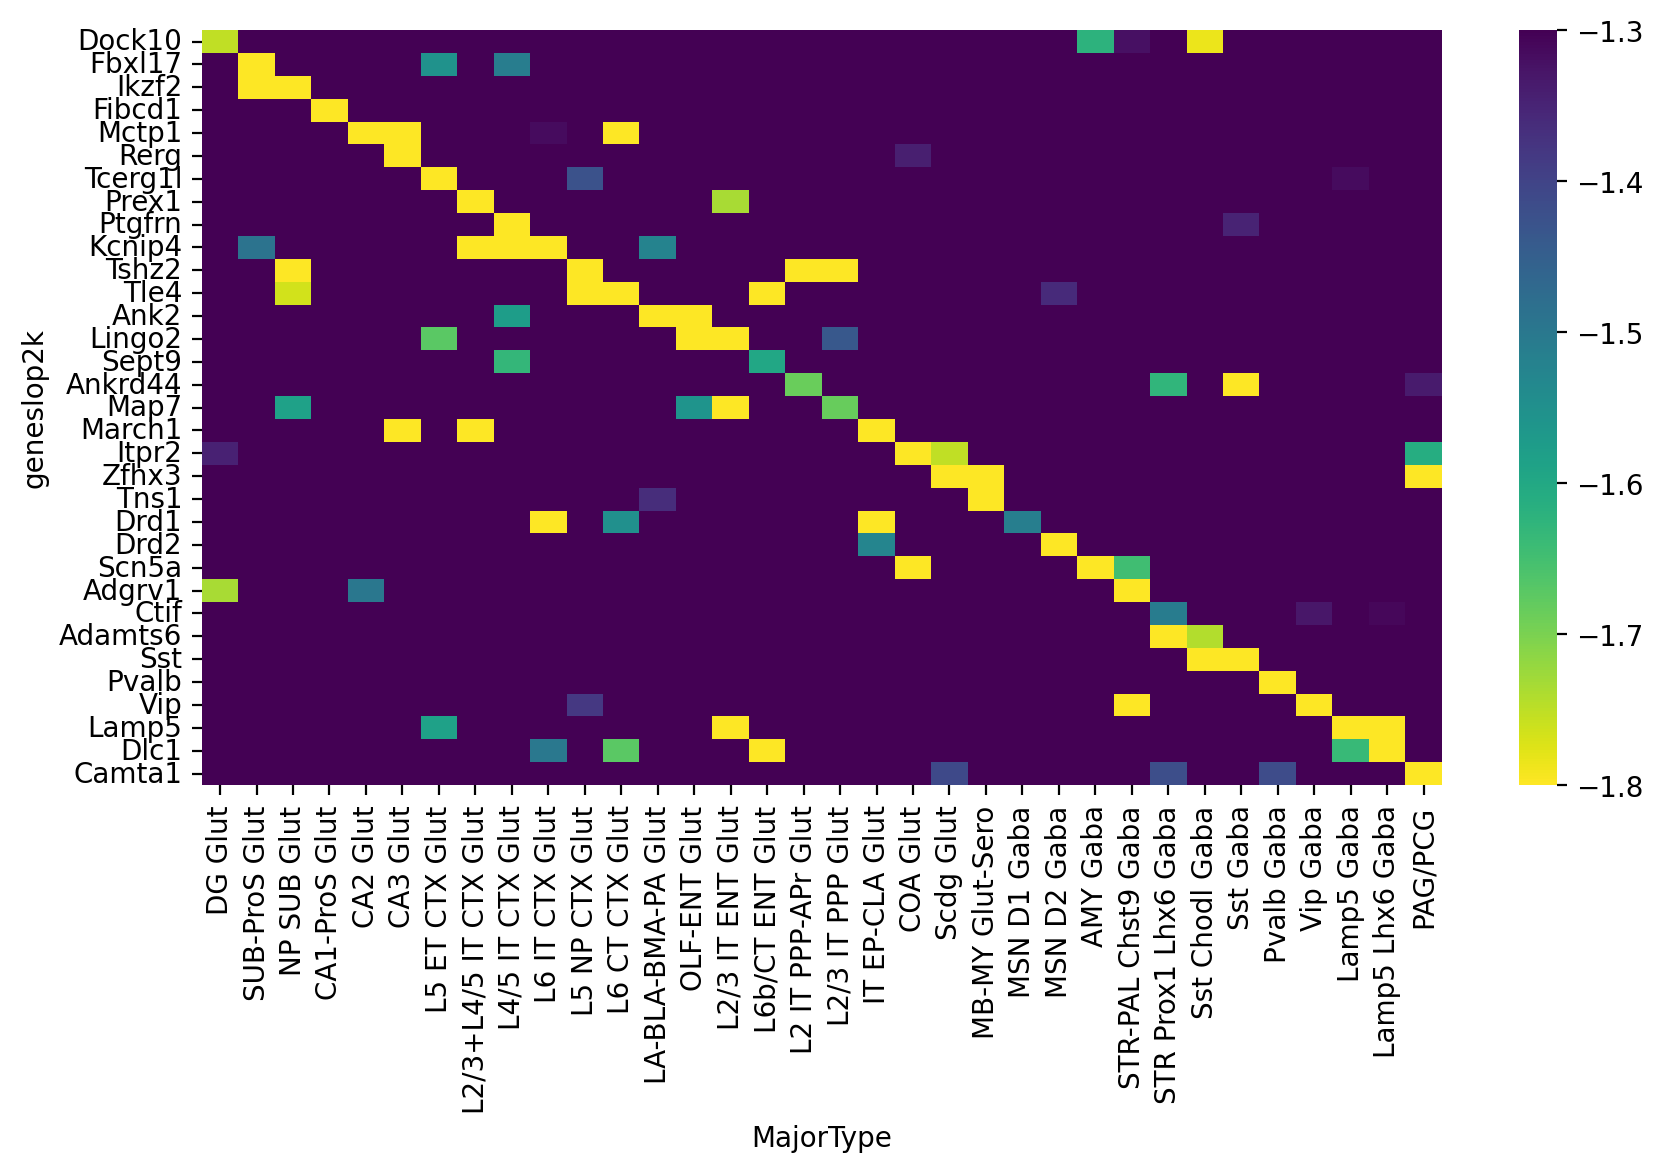

In [257]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
kwargs = {'rasterized':True}

sns.heatmap(to_plot, 
            ax=ax, 
            cmap="viridis_r", 
            xticklabels=True, 
            yticklabels=True,
            vmin=-1.8,
            vmax=-1.3,
           **kwargs)

fig.savefig('CellType.Marker.pdf', bbox_inches = 'tight')